## This is the model to upload onto Streamlit

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pickle 

In [2]:
np.random.seed(42)

## Data Curation

In [3]:
ladies = pd.read_csv('lyrics_and_artist.csv', encoding='latin-1')
ladies.head()

,lyrics,artist
0,"I've been drinkin', I've been drinkin'",beyonce
1,I get filthy when that liquor get into me,beyonce
2,"I've been thinkin', I've been thinkin'",beyonce
3,Why can't I keep my fingers off it?,beyonce
4,"Baby, I want you, now-now",beyonce


In [4]:
ladies['lyrics'].replace({'<|endoftext|>': None}, inplace=True)
ladies.dropna(inplace=True)

In [5]:
ladies.shape

(9488, 2)

In [6]:
ladies['artist'] = ladies['artist'].map({'beyonce': 0, 'rihanna':1})
ladies.head()
# conversion of beyonce/rihanna into binary labels

,lyrics,artist
0,"I've been drinkin', I've been drinkin'",0
1,I get filthy when that liquor get into me,0
2,"I've been thinkin', I've been thinkin'",0
3,Why can't I keep my fingers off it?,0
4,"Baby, I want you, now-now",0


## Baseline Accuracy

In [7]:
ladies['artist'].value_counts(normalize=True)
# baseline

0    0.520341
1    0.479659
Name: artist, dtype: float64

## Modeling Setup

In [8]:
X = ladies['lyrics']
y = ladies['artist']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=42)

## CV Pre-Processing w/ stopwords REMOVED

In [10]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(X_train)

# fit cv on corpus

CountVectorizer(stop_words='english')

In [11]:
X_train = cvec.transform(X_train)
 # transform corpus

In [12]:
X_train.shape

(6641, 3236)

In [13]:
# transform test
X_test = cvec.transform(X_test)

In [14]:
X_test.shape

(2847, 3236)

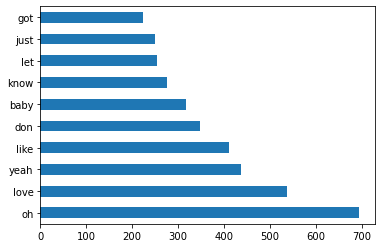

In [15]:
# convert traning data to dataframe

X_train_ladies = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
X_train_ladies.sum().sort_values(ascending=False).head(10).plot(kind='barh');

## Modeling Setup

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=42)

## Baseline Accuracy

In [17]:
y_test.value_counts(normalize=True)

0    0.520197
1    0.479803
Name: artist, dtype: float64

## CV-NB Pipeline Setup

In [18]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('svm', SVC())
])

## GridSearchCV

In [19]:
pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [20]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [21]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svm', SVC())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [22]:
print(gs.best_score_)

0.8113240773477658


In [23]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9360036139135672, 0.8113804004214963)

In [24]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

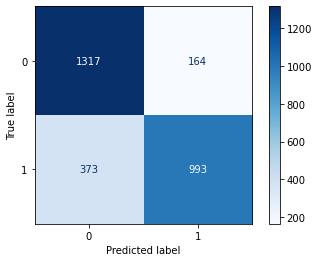

In [25]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [26]:
spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8892640108035111


In [69]:
accur = (tn + tp) / (tp + fp + tn + fn)

print('Accuracy:', accur)

Accuracy: 0.8384264137688795


## CV Pre-Processing w/ stopwords 

In [27]:
cvec = CountVectorizer()
cvec.fit(X_train)

CountVectorizer()

In [28]:
X_train = cvec.transform(X_train)

In [29]:
X_train.shape

(6641, 3471)

In [30]:
X_test = cvec.transform(X_test)

In [31]:
X_test.shape

(2847, 3471)

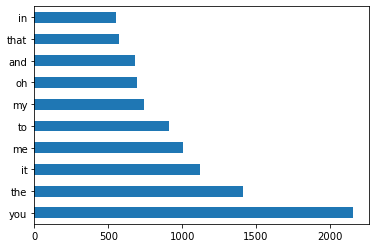

In [32]:
X_train_ladies = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
X_train_ladies.sum().sort_values(ascending=False).head(10).plot(kind='barh');

## Modeling

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=42)

In [34]:
y_test.value_counts(normalize=True)

0    0.520197
1    0.479803
Name: artist, dtype: float64

In [35]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('svm', SVC())
])

In [36]:
pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [37]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [38]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svm', SVC())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [39]:
print(gs.best_score_)

0.8113240773477658


In [40]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9360036139135672, 0.8113804004214963)

In [64]:
with open('svc.pkl', 'wb') as pickle_out:
    pickle.dump(gs, pickle_out)

In [41]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

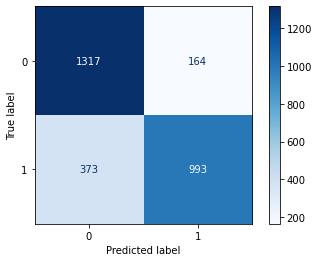

In [42]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [43]:
spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8892640108035111


In [70]:
accur = (tn + tp) / (tp + fp + tn + fn)

print('Accuracy:', accur)

Accuracy: 0.8384264137688795


------------------------------------------------------------------------------------------------------------------

## Pre-Processing w/ TFID + stopwords REMOVED

In [44]:
tvec = TfidfVectorizer(stop_words='english')

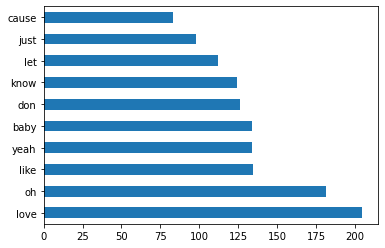

In [45]:
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [46]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', SVC())
])

In [47]:
pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [48]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

In [49]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svm', SVC())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [50]:
gs_tvec.score(X_train, y_train), gs_tvec.score(X_test, y_test)

(0.9805752145761181, 0.8384264137688795)

In [51]:
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8858879135719109


In [67]:
accur = tn + tp / (tp + fp + tn + fn)

print('Accuracy:', accur)

Accuracy: 1312.3775904460836


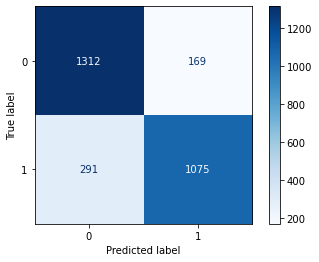

In [52]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');

## Pre-Processing w/ TFID + NO stopwords removed

In [53]:
tvec = TfidfVectorizer()

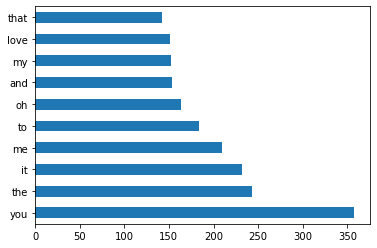

In [54]:
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [55]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svm', SVC())
])

In [56]:
pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [57]:
gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

In [58]:
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svm', SVC())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [59]:
# Score model on training + test sets
gs_tvec.score(X_train, y_train), gs_tvec.score(X_test, y_test)

(0.9805752145761181, 0.8384264137688795)

In [60]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8858879135719109


In [68]:
accur = tn + tp / (tp + fp + tn + fn)

print('Accuracy:', accur)

Accuracy: 1312.3775904460836


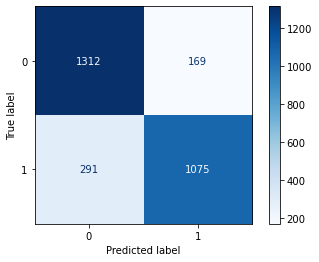

In [61]:
# visualize this

plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');